In [25]:
import pandas as pd
import numpy as np
import math
from opcua import Client
import sys
import time
from scipy import stats
import random
import matplotlib.pyplot as plt
from opcua import ua

In [26]:
servoDF = pd.read_excel("servoDB.xlsx")

In [27]:
x1 = servoDF.loc[:, "Current"]
x2 = servoDF.loc[:, "Following Error"]

In [28]:
means = np.mean([x1, x2], axis = 1)
stdevs = np.std([x1, x2], axis = 1)

dist = stats.multivariate_normal(means, stdevs)
proba = dist.pdf(np.array([x1, x2]).T)

In [29]:
from IPython.display import clear_output

In [30]:
url = "opc.tcp://" # // dan sonra ip adresi:port şeklinde yazılacak.
try:
    client = Client(url)
    client.connect()
    print("Connected to opcua server.")
except Exception as err:
    print("Error: ", err)
    sys.exit(1)

Connected to opcua server.


In [ ]:
eps = 1e-21
HealthList = []
newList = []
testList = []
testOklid = []
newOklid = []
counter = 0
intensity = 1
if __name__ == '__main__':
    Current = client.get_node("ns=4;s=|var|CPX-E-CEC-M1.Application.PLC_PRG.iCurrent")
    FollowingError = client.get_node("ns=4;s=|var|CPX-E-CEC-M1.Application.PLC_PRG.iFollowingError")
    State = client.get_node("ns=4;s=|var|CPX-E-CEC-M1.Application.PLC_PRG.iState")
    health = client.get_node("ns=4;s=|var|CPX-E-CEC-M1.Application.PLC_PRG.HealthScore")
    while True:
        stateValue = State.get_value()
        if stateValue == 50:
            currentValue = Current.get_value()
            followingErrorValue = FollowingError.get_value()
            if followingErrorValue < 0:
                followingErrorValue *= -1
            x1 = np.append(x1, [currentValue])
            x2 = np.append(x2, [followingErrorValue])
            proba = dist.pdf(np.array([x1, x2]).T)
            oklid = math.sqrt((currentValue - means[0])**2 + (followingErrorValue - means[1])**2)
            if proba[-1] < eps:
                newList = np.append(newList, 1)
                newOklid = np.append(newOklid, oklid)
            else:
                newList = np.append(newList, 0)
                newOklid = np.append(newOklid, oklid)
            Error = 0
            HealthScore = 100
            testList = newList[-intensity:]
            testOklid = newOklid[-intensity:]
            if (np.count_nonzero(testList == 1)) == len(testList):
                for i in testOklid:
                    Error = Error + (i * 0.4)
            time.sleep(.2)
            if (HealthScore - Error) < 0:
                HealthScore = 0
            else:
                HealthScore = HealthScore - Error
            #print(Error)
            #print(testList)
            #print(testOklid)
            HealthScore = int(HealthScore)
            variant_value = ua.Variant(HealthScore, ua.VariantType.Int16)
            health.set_value(variant_value)
            clear_output(wait=True)
            print(f"Current : {currentValue}")    
            print(f"Following Error : {followingErrorValue}")
            print(f"Health Score : {HealthScore}")
            #print(newOklid)
            #print(newList)
            time.sleep(1)
        if stateValue == 100:
            break
        time.sleep(.2)            

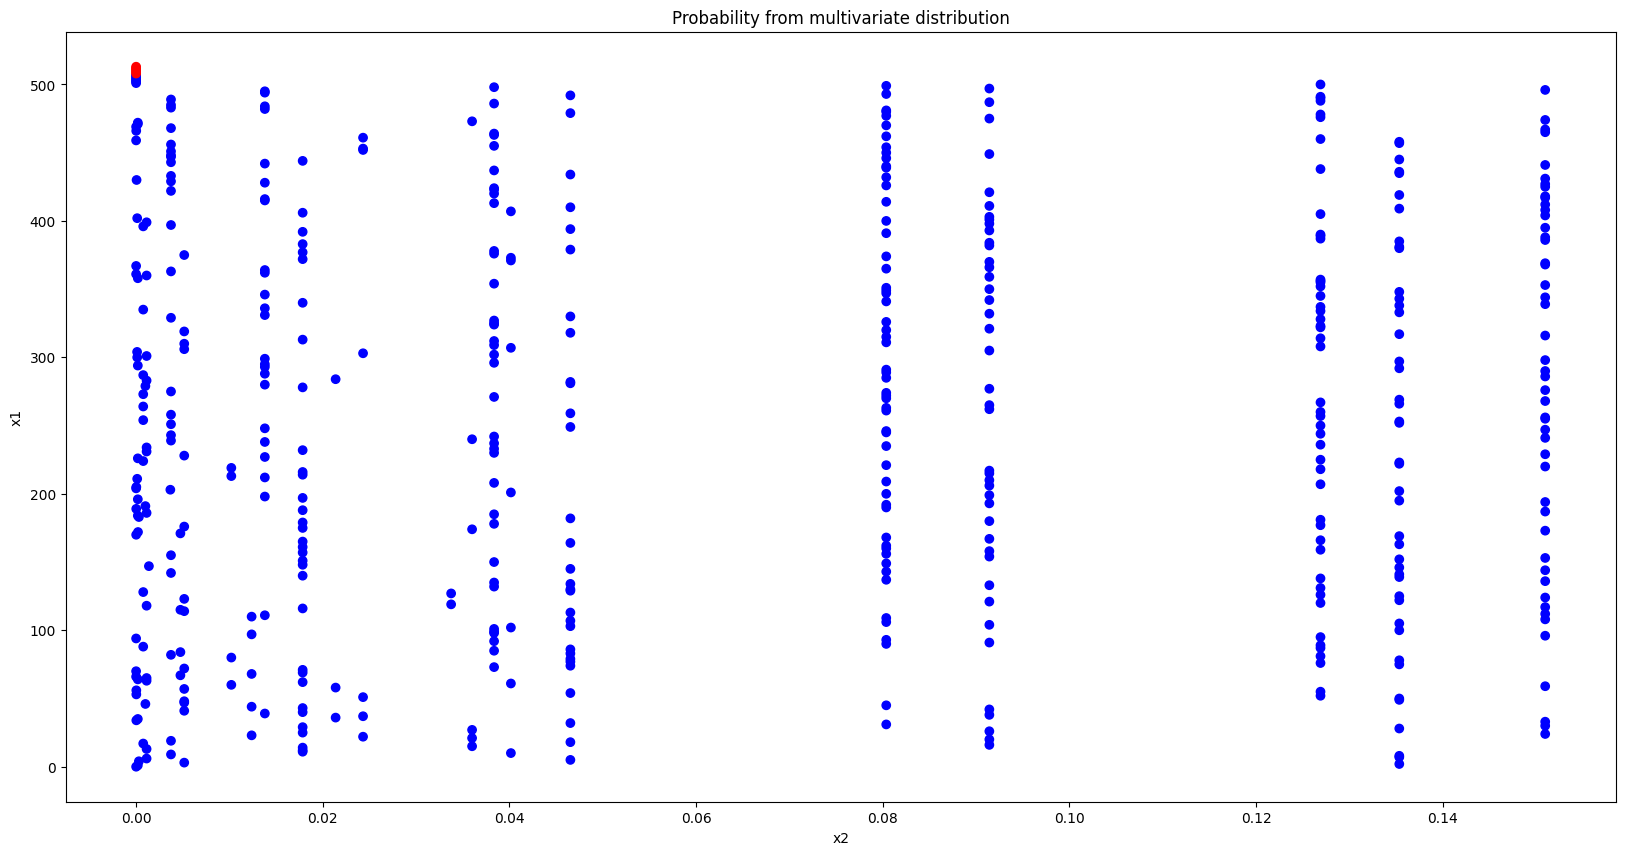

In [16]:
y1 = np.arange(0, len(proba))
plt.figure(figsize=(20, 10))
plt.title(f"Probability from multivariate distribution")
plt.xlabel("x2")
plt.ylabel("x1")
eps = 1e-21
plt.scatter(proba, y1,  c=np.where(proba<eps, "red", "blue"))
plt.show()